# Gaussian Process Audio Model Frequency Domain

Iniitialization:

In [71]:
import pydub as pd
import numpy as np
from scipy import fftpack

pd.AudioSegment.converter = "C:\\ffmpeg\\bin\\ffmpeg.exe"

Open the audio file:

In [72]:
song = pd.AudioSegment.from_wav('guitar.wav')

# conver to mono if it's necessary:
#song = song.set_channels(1)

# take first 8 seconds only (can be changed):
test_song = song[0:8000]

# get size of the sample (number of counts):
test = test_song.get_array_of_samples()
num = np.size(test)
num

352800

Listen it if you want:

In [73]:
test_song

Visualize the song:

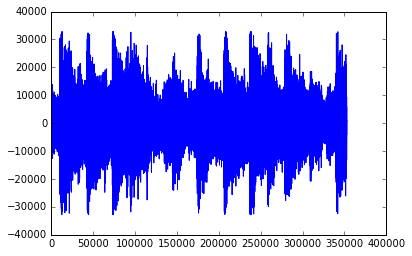

In [74]:
import matplotlib.pyplot as mp
% matplotlib inline

mp.plot(test)

Convert to the overlaped frames:

In [75]:
# windows size
win_size = test_song.frame_rate//5 # 200 ms per frame

# window function
hanning_win = np.hanning(win_size)

# output
sample_time = np.zeros((np.shape(np.arange(0, num, win_size//2))[0],win_size))

# for all windows, half overlapping (incrementing by win_size//2)
for win_start in np.arange(0, num, win_size//2):
    win_internal_size = np.min([win_start+win_size, num]) - win_start
    data_frame = test[win_start:win_start+win_internal_size] * hanning_win[0:win_internal_size]
    sample_time[win_start//(win_size//2),:] = np.pad(data_frame, [(0, win_size - np.size(data_frame))], mode='constant')

Convert to frequency domain:

In [76]:
sample_freq = fftpack.fftshift(fftpack.fft(sample_time))

Separate to amplitude and phase:

In [77]:
amplitude = np.abs(sample_freq)

phase = np.angle(sample_freq)

## Amplitude modeling

Select amplitude as an input:

In [78]:
sample=amplitude

np.shape(sample)

(80, 8820)

Define model parameters:

In [79]:
# number of frames
N = sample.shape[0]

# dimensionality of observed space
D = sample.shape[1]

# dimensionality of latent space
Q = 20

# initialize the latent variable
X = np.zeros((N,Q))

Visualize the amplitude (optionaly):

 ...]

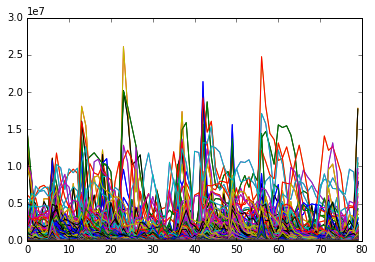

In [80]:
mp.plot(sample)

Normalization:

In [81]:
sample_mean = np.mean(sample)
sample_std = np.std(sample)
sample_norm = (sample - sample_mean)/sample_std # normalization

print(sample_norm)

[[-0.20134404 -0.20133804 -0.20131143 ..., -0.20130288 -0.20131143
  -0.20133804]
 [-0.20134993 -0.20135518 -0.20133775 ..., -0.20134709 -0.20133775
  -0.20135518]
 [-0.2013573  -0.20135087 -0.20132126 ..., -0.20131796 -0.20132126
  -0.20135087]
 ..., 
 [-0.20133861 -0.20133068 -0.20132849 ..., -0.20135016 -0.20132849
  -0.20133068]
 [-0.20133217 -0.20133082 -0.20134337 ..., -0.20130908 -0.20134337
  -0.20133082]
 [-0.20132757 -0.20130876 -0.20130614 ..., -0.20134122 -0.20130614
  -0.20130876]]


Initialize the model:

In [82]:
# import Gaussian process library
import GPy

# define the kernel function (RBF kernel for example):
kernel = GPy.kern.RBF(Q,ARD=True)

# define the model (Gaussian Process Latent Variable Model)
m = GPy.models.GPLVM(sample_norm, input_dim=Q, kernel=kernel, init='PCA')

Perform learning (note that, normally it takes less than 1 minute for 100 iterations):

In [83]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=100)

The latent dimensions can be visualized (optionaly):

 C:\Users\Maxim\Anaconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


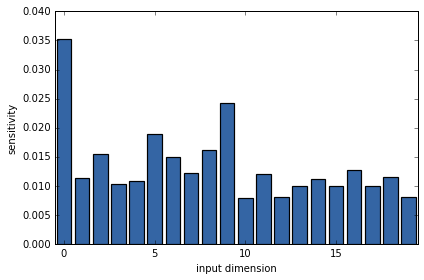

In [84]:
kernel.plot_ARD()

Extract latent frames:

In [85]:
X = m.X

Visualize the latent frames (optionaly):

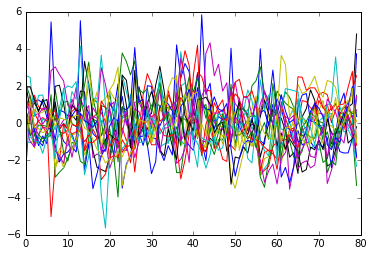

In [86]:
mp.plot(X)

## Amplitude synthesizing

Select the lenght of a new amplitude:

In [87]:
# (!)choose by comment/uncomment one of the following:

# the same size as in the original song
N_synt = N

# any different length (in this case a new phase should be syntesized also)
#N_synt = N*2 # N*2 - twice longer than input song, N*3 - three times longer, etc.

Define a function for predicting a new latent frame:

In [88]:
def predict_new_latent_frame(N,X,kern,Kx_inv,X_old):
    
    k_x = kern.K(X[0:N-1],X_old)
    #k_xx = kern.K(X_old,X_old)

    meann = np.matmul(np.matmul(np.transpose(X[1:N]),Kx_inv),k_x).flatten()
    #cov = (k_xx - np.matmul(np.matmul(np.transpose(k_x),Kx_inv),k_x)) * np.eye(Q)
    
    #R = np.random.multivariate_normal(meann,cov)
    R = meann
    
    return R

Perform prediction of the new latent frames:

In [89]:
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx = kernel.K(X[0:N-1])
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_latent_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
np.shape(X_synt)

(80, 20)

Predicted latent frames can be visualized (optionaly):

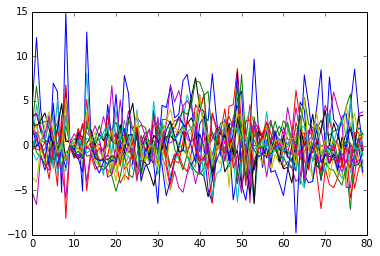

In [90]:
mp.plot(X_synt)

From predicted latent frames syntesize new amplitude:

In [91]:
Y_synt = np.zeros((N_synt,D))

Ky = kernel.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample_norm)
k_y = kernel.K(X,X_synt)
k_yy = kernel.K(X_synt,X_synt)

meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))

for i in range(D):
    Y_synt[:,i] = np.matmul(cov,np.random.randn(N_synt)) + meann[i,:]

np.shape(Y_synt)

(80, 8820)

Perform denormalization:

In [92]:
Y_synt_denorm = Y_synt*sample_std + sample_mean

Save new (predicted) amplitude:

In [93]:
amplitude_new = Y_synt_denorm

## Phase modeling (optionaly)

Select phase as an input:

In [55]:
sample=phase

np.shape(sample)

(80, 8820)

Define model parameters:

In [56]:
# number of frames
N = sample.shape[0]

# dimensionality of observed space
D = sample.shape[1]

# dimensionality of latent space
Q = 20

# initialize the latent variable
X = np.zeros((N,Q))

Visualize the phase (optionaly):

 ...]

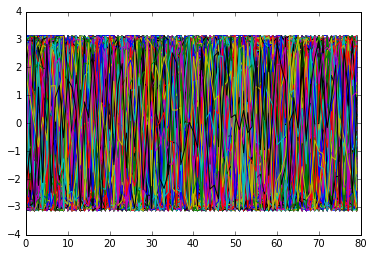

In [57]:
mp.plot(sample)

Normalization:

In [58]:
sample_mean = np.mean(sample)
sample_std = np.std(sample)
sample_norm = (sample - sample_mean)/sample_std # normalization

print(sample_norm)

[[ -2.01249234e-04   1.25174385e+00  -9.55690498e-01 ...,  -6.39541970e-01
    9.55288000e-01  -1.25214634e+00]
 [  1.73152386e+00   5.02149657e-01  -4.77528289e-01 ...,   1.13497527e+00
    4.77125791e-01  -5.02552155e-01]
 [  1.73152386e+00   1.66042176e+00   6.19389771e-04 ...,  -1.71868540e+00
   -1.02188824e-03  -1.66082425e+00]
 ..., 
 [  1.73152386e+00  -6.38151959e-01   7.71744401e-01 ...,  -1.61297718e+00
   -7.72146899e-01   6.37749461e-01]
 [ -2.01249234e-04   1.37726575e+00   1.11735486e+00 ...,   5.35961263e-01
   -1.11775736e+00  -1.37766825e+00]
 [  1.73152386e+00  -1.50536416e-01   1.65771959e+00 ...,   6.11411416e-01
   -1.65812209e+00   1.50133918e-01]]


Initialize the model:

In [59]:
# import Gaussian process library
import GPy

# define the kernel function:
kernel = GPy.kern.MLP(Q,ARD=True)

# define the model (Gaussian Process Latent Variable Model)
m = GPy.models.GPLVM(sample_norm, input_dim=Q, kernel=kernel, init='PCA')

Perform learning (note that, normally it takes less than 1 minute for 100 iterations):

In [60]:
m.optimize(messages=True, optimizer = 'SCG',max_iters=100)

Extract latent frames:

In [61]:
X = m.X

Visualize the latent frames (optionaly):

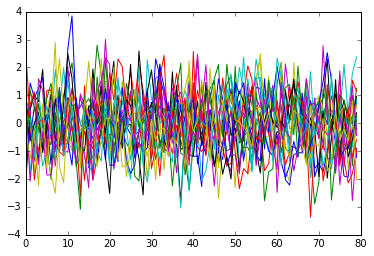

In [62]:
mp.plot(X)

## Phase synthesizing (optionaly)

Perform prediction of the new latent frames:

In [63]:
X_synt = np.zeros((N_synt,Q))
X_last = X[N-1:N]
Kx = kernel.K(X[0:N-1])
Kx_inv = np.linalg.inv(Kx)

for i in range(N_synt):
    X_synt[i,:] = predict_new_latent_frame(N,X,kernel,Kx_inv,X_last.reshape(1,Q))
    X_last = X_synt[i,:]
    
np.shape(X_synt)

(80, 20)

Predicted latent frames can be visualized (optionaly):

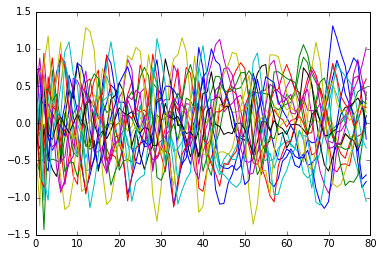

In [64]:
mp.plot(X_synt)

From predicted latent frames syntesize new phase:

In [65]:
Y_synt = np.zeros((N_synt,D))

Ky = kernel.K(X)
Ky_inv = np.linalg.inv(Ky)
Y_t = np.transpose(sample_norm)
k_y = kernel.K(X,X_synt)
k_yy = kernel.K(X_synt,X_synt)

meann = np.matmul(np.matmul(Y_t,Ky_inv),k_y)
cov = (k_yy - np.matmul(np.matmul(np.transpose(k_y),Ky_inv),k_y))

for i in range(D):
    Y_synt[:,i] = np.matmul(cov,np.random.randn(N_synt)) + meann[i,:]

np.shape(Y_synt)

(80, 8820)

Perform denormalization:

In [66]:
Y_synt_denorm = Y_synt*sample_std + sample_mean

Save new (predicted) phase:

In [67]:
phase_new = Y_synt_denorm

## Convert back to audio

Merge back to frequency, then back to time domain, then unoverlap all the frames and obtain an audio file:

In [97]:
# from amplitude and phase convert back to frequency domain:

# (!)choose by comment/uncomment one of the following: 
# by using old phase (the lenght of the predicted sample should be the same as the input)
sample_X = amplitude_new*np.cos(phase) + amplitude_new*np.sin(phase)*1j
# or by using the new predicted phase:
#sample_X = amplitude_new*np.cos(phase_new) + amplitude_new*np.sin(phase_new)*1j

# convert back to time domain
sample_t = np.real(fftpack.ifft(fftpack.ifftshift(sample_X)))

# unoverlap all the frames
N_res = num*(N_synt//N)
result = np.zeros(N_res, dtype='float64')
for win_start in np.arange(0, N_res, win_size//2):
    win_internal_size = np.min([win_start+win_size, N_res]) - win_start
    result[win_start:win_start+win_internal_size] += sample_t[win_start//(win_size//2),0:(win_start+win_internal_size-win_start)]
    
# back to integer
Z = np.int16(np.round(result))

# convert back to audio
test_synt = pd.AudioSegment(
    Z.tobytes(), 
    frame_rate=test_song.frame_rate,
    sample_width=2, 
    channels=1
)

Visualize the new predicted audio (optionaly):

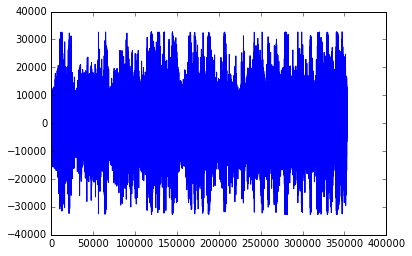

In [98]:
mp.plot(Z)

You can also play it:

In [99]:
test_synt

Save into the file:

In [28]:
test_synt.export("test.wav", format="wav")

<_io.BufferedRandom name='test.wav'>